In [1]:
#run_folder = '~/car/tracks/sidewalk/routes/N/runs/20'
run_folder = '~/car/tracks/desk/routes/I/runs/95'
              

## Imports and Helpers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
import subprocess
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

In [3]:
import plotly.tools as tls
def iplot():
    plotly_fig = tls.mpl_to_plotly(plt.figure(1))
    py.iplot(plotly_fig, show_link=False)

In [4]:
def video_tag(path,width=300,height=240,title=""):
    '''
    generates an HTML fragmentfor displaying the video in path in the notebook
    '''
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [5]:
def table_tag(fragments, columns):
    column = 1
    s = '<table><tr>'
    for fragment in fragments:
        s = s + '<td>' + fragment + '</td>'
        column = column + 1
        if column > columns:
            s = s + '</tr><tr>'
            column = 1
    s = s + '</td></tr></table>'
    return s

In [6]:
def big_figure():
    fig = plt.figure()
    fig.set_size_inches(w=15,h=10)
    return fig

In [7]:
def diff_n(v,n=1):
    rv = np.zeros_like(v,dtype=np.float)
    rv[n:] = np.subtract(v[n:],v[0:-n])
    return rv

## Settings

In [8]:
front_meters_per_odometer_tick = 0.002528
rear_meters_per_odometer_tick = 0.002528
front_wheelbase_width_in_meters = 0.2413
rear_wheelbase_width_in_meters = 0.2667
wheelbase_length_in_meters = 0.33655

## Analysis

In [9]:
route_folder = os.path.dirname(os.path.dirname(run_folder)) # two folders up
route_folder

'~/car/tracks/desk/routes/I'

In [10]:
def get_config(config_path = 'cat '+run_folder+"/config.json"):
    ''' reads .ini style configuration or run files '''

    config_text = subprocess.check_output(config_path,shell=True).decode('utf-8')
    run_config = {}
    for l in config_text.split('\n'):
        try:
            k,v = l.split("=")
        except:
            continue
        k = k.strip()
        v = v.strip()
        try:
            v=float(v)
        except:
            pass
        run_config[k] = v
    return run_config

run_config = get_config()
print(run_config)
    
    



{'max_a': 1.0, 'prune_tolerance': 0.02, 'v_k_d': 0.5, 'max_v': 2.0, 'prune_max': 0.5, 'steering_k_i': 0.0, 't_ahead': 0.3, 'slip_slop': 0.5, 'optimize_velocity': 1.0, 'd_ahead': 0.1, 'v_k_p': 6.0, 'k_smooth': 0.4, 'steering_k_d': 5.0, 'track_name': 'desk', 'v_k_i': 0.0, 'route_name': 'I', 'capture_video': 0.0, 'crash_recovery': 0.0, 'steering_k_p': 80.0, 'slip_rate': 0.2}


In [11]:
# Create / Show videos


video_tags = []
for f in ['video_left','video_right']:
    mp4_path = os.path.join(run_folder,f+'.mp4')
    if not os.path.exists(mp4_path):
        avi_path = os.path.join(run_folder,f+'.avi')
        if os.path.exists(avi_path):
            s = 'ffmpeg -i "{0}" -vcodec h264 -acodec copy "{1}"'.format(avi_path,mp4_path)
            subprocess.call(s,shell=True)
    if os.path.exists(mp4_path):
        video_tags.append(video_tag(mp4_path,title=f))
    else:
        print("couldn't find ", mp4_path)
display.display(display.HTML(table_tag(video_tags, columns=2)))


couldn't find  ~/car/tracks/desk/routes/I/runs/95/video_left.mp4
couldn't find  ~/car/tracks/desk/routes/I/runs/95/video_right.mp4


In [12]:
tdt = pd.read_csv(os.path.join(run_folder,'td.csv'),parse_dates=(['timestamp']))


In [13]:
tdt.columns

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl_a',
       'odo_fl_a_us', 'odo_fl_b', 'odo_fl_b_us', 'odo_fl_ab_us', 'odo_fr_a',
       'odo_fr_a_us', 'odo_fr_b', 'odo_fr_b_us', 'odo_fr_ab_us', 'odo_bl_a',
       'odo_bl_a_us', 'odo_bl_b', 'odo_bl_b_us', 'odo_bl_ab_us', 'odo_br_a',
       'odo_br_a_us', 'odo_br_b', 'odo_br_b_us', 'odo_br_ab_us', 'odo_spur',
       'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax', 'ay', 'az', 'imu_calib'],
      dtype='object')

In [14]:
run_state = pd.read_csv(os.path.join(run_folder,'state.csv'),parse_dates=(['timestamp']))
run_state.t = (run_state.ms - run_state.ms.values[0])/1000.


In [15]:
def get_td(folder):
    td = pd.read_csv(os.path.join(folder,'td.csv'),parse_dates=(['timestamp']))
    td.t = (td.ms - td.ms.values[0])/1000.
    
        
    #generate some extra columns
    for p in ['fl','fr','bl','br']:
        if not 'odo_'+p in td.columns:
            td['odo_'+p] = td['odo_'+p+'_a'] + td['odo_'+p+'_b']
            td['odo_'+p+"_us"] = tdt[['odo_'+p+'_a_us', 'odo_'+p+'_b_us']].max(axis=1)
        td[p] = td['odo_'+p] - td['odo_'+p][0]

    # create td.heading from yaw, represents total turn angle from start
    dy = td.yaw.diff()
    td.heading = np.cumsum(dy + 360*(dy<-190)-360*(dy>190))
    
    # create center wheels
    td.fc = (td.fl+td.fr)/2. # front center
    td.bc = (td.bl+td.br)/2. # back center
    return td


In [16]:
route = get_td(route_folder)
run = get_td(run_folder)
print(run.columns)

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl_a',
       'odo_fl_a_us', 'odo_fl_b', 'odo_fl_b_us', 'odo_fl_ab_us', 'odo_fr_a',
       'odo_fr_a_us', 'odo_fr_b', 'odo_fr_b_us', 'odo_fr_ab_us', 'odo_bl_a',
       'odo_bl_a_us', 'odo_bl_b', 'odo_bl_b_us', 'odo_bl_ab_us', 'odo_br_a',
       'odo_br_a_us', 'odo_br_b', 'odo_br_b_us', 'odo_br_ab_us', 'odo_spur',
       'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax', 'ay', 'az', 'imu_calib',
       'odo_fl', 'odo_fl_us', 'fl', 'odo_fr', 'odo_fr_us', 'fr', 'odo_bl',
       'odo_bl_us', 'bl', 'odo_br', 'odo_br_us', 'br'],
      dtype='object')


In [17]:
big_figure()
plt.plot(run.heading)
iplot()

In [18]:
fig = big_figure()
plt.title('fc wheel distance vs. Steering')
plt.plot(run.fc,run.str,color='g',label='run')
plt.plot(route.fc,route.str,color='b',label='route')
#plt.legend();
py.iplot_mpl(fig)


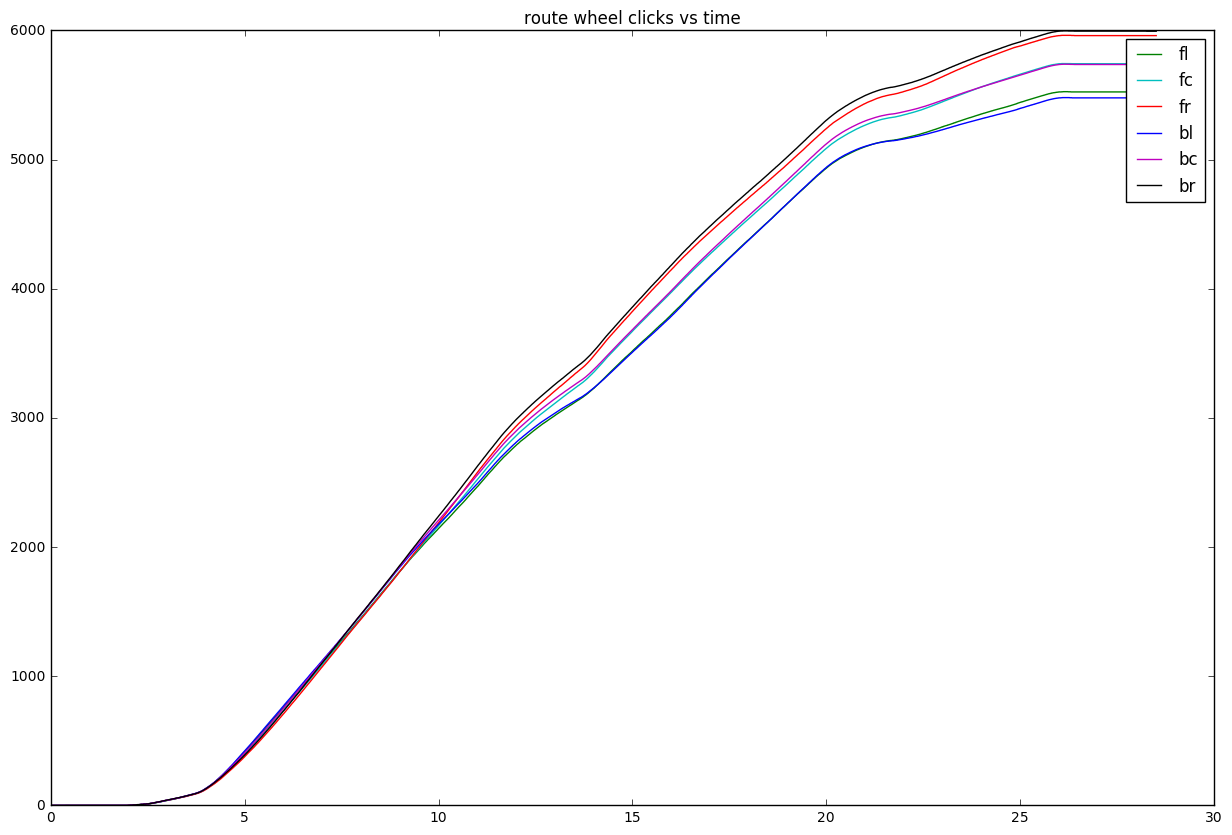

In [19]:
fig = plt.figure()
fig.set_size_inches(w=15,h=10)


plt.title('route wheel clicks vs time')
plt.plot(route.t,route.fl,color='g',label='fl')
plt.plot(route.t,route.fc,color='c', label='fc')
plt.plot(route.t,route.fr,color='r', label='fr')

plt.plot(route.t,route.bl,color='b', label='bl')
plt.plot(route.t,route.bc,color='m', label='bc')
plt.plot(route.t,route.br,color='k', label='br')
plt.legend();

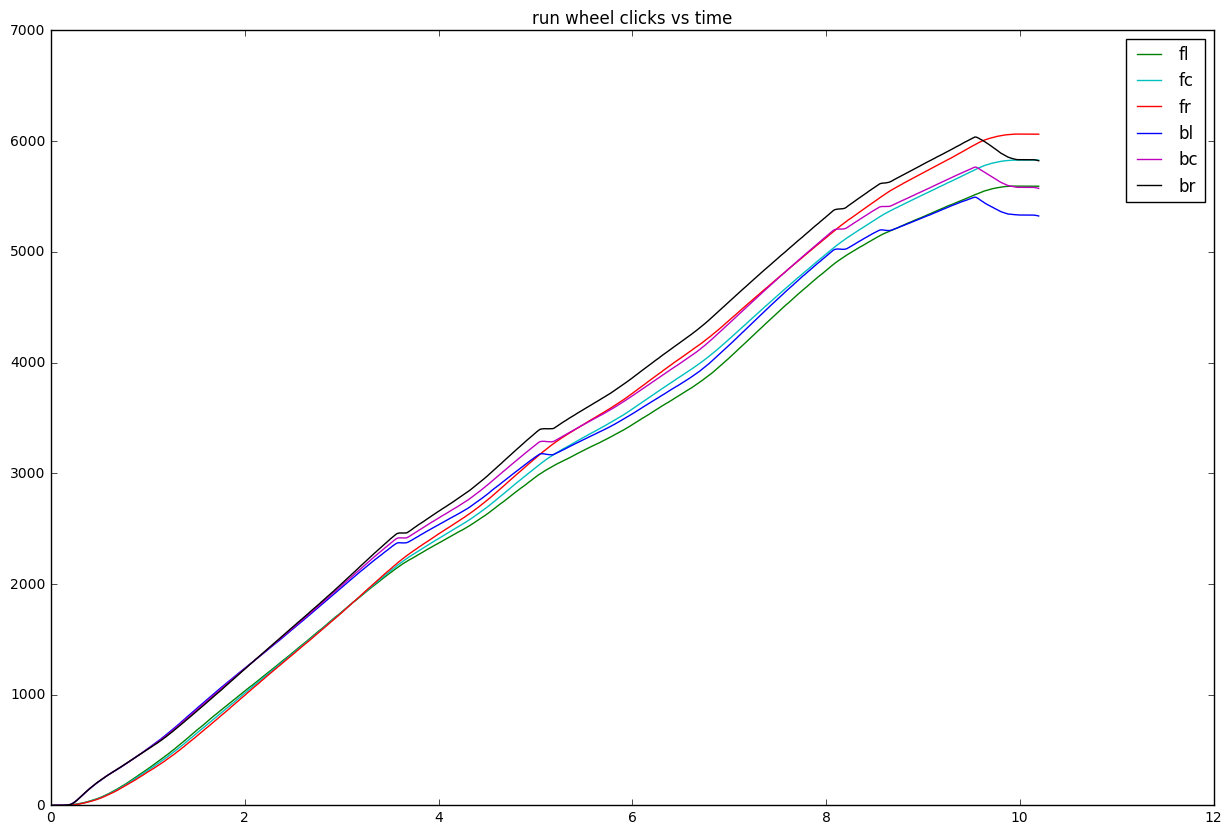

In [20]:
fig = plt.figure()
fig.set_size_inches(w=15,h=10)

ratio = 1 #.25
plt.title('run wheel clicks vs time')
plt.plot(run.t,run.fl*ratio,color='g',label='fl')
plt.plot(run.t,run.fc*ratio,color='c', label='fc')
plt.plot(run.t,run.fr*ratio,color='r', label='fr')

plt.plot(run.t,run.bl,color='b', label='bl')
plt.plot(run.t,run.bc,color='m', label='bc')
plt.plot(run.t,run.br,color='k', label='br')
plt.legend();

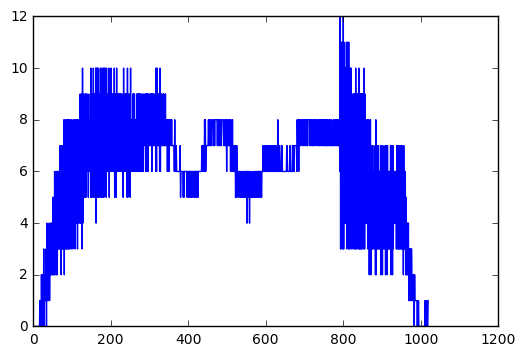

In [21]:
plt.plot(np.abs(np.diff(run.odo_fr,n=1)))

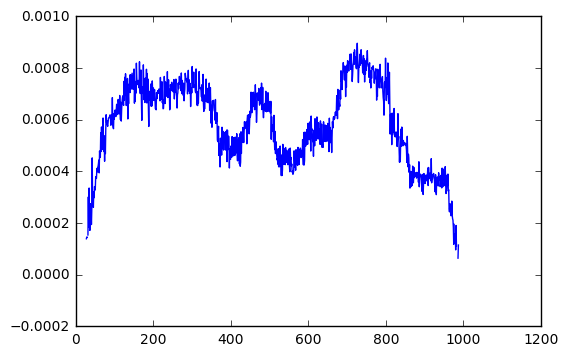

In [22]:
le = np.seterr(divide = 'ignore')
with np.errstate(invalid='ignore', divide='ignore'):
    plt.plot(np.divide(np.diff(run.odo_fl,n=1).astype(np.float),np.diff(run.odo_fl_us,n=1).astype(float)))
#np.seterr(le)

In [23]:
def raw_v(odo,us,meters_per_odometer_tick):
    v = np.zeros_like(odo).astype(np.float)
    
    last_us = 0
    last_odo = 0
    for i in range(len(odo)):
        if last_us==0:
            v[i]==0.
            last_us = us[i]
            last_odo = odo[i]
        elif last_odo == odo[i]:
            v[i] = v[i-1]
        else:
            v[i] =(odo[i]-last_odo)*meters_per_odometer_tick / (us[i] - last_us)*1E6
            last_odo = odo[i]
            last_us = us[i]
    return v
        
    #dx = np.diff(odo).astype(np.float)*meters_per_odometer_tick
    #dt = np.diff(us).astype(np.float)/1E6
    #with np.errstate(invalid='ignore', divide='ignore'):
    #    v[1:] = np.where(dt > 0, dx/dt,0)
    #return v




In [24]:
def v_ab(df, wheel):
    
    last_us = 0
    last_odo = 0
    
    ab_us = df['odo_'+wheel+"_ab_us"]
    odo_a = df['odo_'+wheel+"_a"]
    odo_b = df['odo_'+wheel+"_b"]
    odo = df['odo_'+wheel]
    v = np.zeros_like(ab_us).astype(np.float)

    for i in range(len(odo)):
        if i==0:
            v[i]==0.
        else:
            # forward
            dt = ab_us[i]-ab_us[i-1]
            
            if odo_b[i] > odo_b[i-1]:
                ds = odo_b[i]-odo_b[i-1]
            elif odo_a[i] < odo_a[i-1]:
                ds = odo_a[i] - odo_a[i-1]
            else:
                ds = 0
            if ds == 0:
                v[i] = v[i-1]
            else:
                v[i] = float(ds)/dt*1600
#            v[i] =(odo[i]-last_odo)*meters_per_odometer_tick / (us[i] - last_us)*1E6
#            last_odo = odo[i]
#            last_us = us[i]
    return v

#    '''returns velocity based on time to travel sensor a-b gap'''
#    return 1/ab_us*1600

In [25]:
circumference = front_meters_per_odometer_tick * 128

In [26]:
circumference / 1600

0.00020224

In [27]:
circumference / .064

5.056

In [28]:
class KalmanFilter:
    def __init__(self, mean, variance):
        self.mean = float(mean)
        self.variance = float(variance)
    def measure(self,mean,variance):
        self.mean = (self.variance*float(mean)+self.mean*variance)/(self.variance+float(variance))
        self.variance = 1/((1/variance)+(1/self.variance))
    def update(self,distance,variance):
        self.mean += distance
        self.variance += variance                                                                    

In [29]:
def kalman_v(ax,vraw,measure_variance=0.1**2):
    f = KalmanFilter(0,0)
    k_v = []
    for i,v in enumerate(vraw):
        f.update(0.01*ax[i],0.01**2)
        f.measure(v,measure_variance)
        k_v.append(f.mean)
    return np.array(k_v)


In [30]:
run.fr_v = raw_v(run.odo_fr_a,run.odo_fr_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_fr_b,run.odo_fr_b_us, front_meters_per_odometer_tick)
run.fl_v = raw_v(run.odo_fl_a,run.odo_fl_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_fl_b,run.odo_fl_b_us, front_meters_per_odometer_tick)
run.br_v = raw_v(run.odo_br_a,run.odo_br_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_br_b,run.odo_br_b_us, front_meters_per_odometer_tick)
run.bl_v = raw_v(run.odo_bl_a,run.odo_bl_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_bl_b,run.odo_bl_b_us, front_meters_per_odometer_tick)

run.fr_v_ab = v_ab(run, 'fr')
run.fl_v_ab = v_ab(run, 'fl')
run.br_v_ab = v_ab(run, 'br')
run.bl_v_ab = v_ab(run, 'bl')



In [31]:
run.fr_kv = kalman_v(run.ax,run.fr_v)
run.fl_kv = kalman_v(run.ax,run.fl_v)
run.br_kv = kalman_v(run.ax,run.br_v)
run.bl_kv = kalman_v(run.ax,run.bl_v)

In [32]:
ab_variance = 0.01 # 0.1 ** 2
run.fr_kv_ab = kalman_v(run.ax,run.fr_v_ab,measure_variance=ab_variance)
run.fl_kv_ab = kalman_v(run.ax,run.fl_v_ab,measure_variance=ab_variance)
run.br_kv_ab = kalman_v(run.ax,run.br_v_ab,measure_variance=ab_variance)
run.bl_kv_ab = kalman_v(run.ax,run.bl_v_ab,measure_variance=ab_variance)

In [33]:
big_figure()
plt.plot(run.fr_v_ab,color='blue')
plt.plot(run.fr_kv_ab,color='green')
plt.plot(run.fr_kv,color='orange')
iplot()

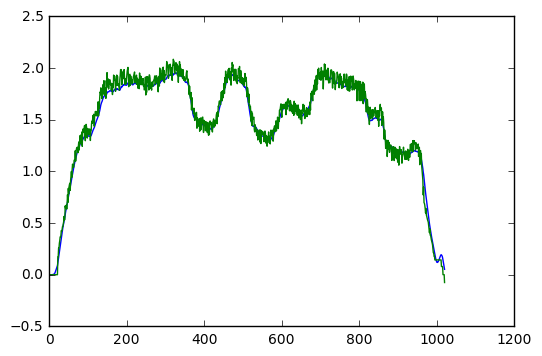

In [34]:
plt.plot(run.fr_kv)
plt.plot(run.fr_v)

In [35]:
def kalman_a(a_raw,measure_variance=10**2):
    f = KalmanFilter(0,0)
    k_a = []
    for i,a in enumerate(a_raw):
        f.update(0, 0.1)
        f.measure(a,measure_variance)
        k_a.append(a.mean)
    return np.array(k_a)

def a_from_v():
    a_raw = diff_n(run_state.v_fr_smooth,2)/diff_n(run_state.t,1)
    a_raw[0]=0.0
    return (a_raw)
    

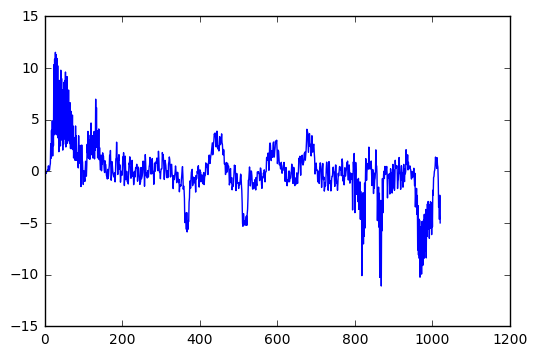

In [36]:
#plt.plot(diff_n(run.fr_v_ab)/diff_n(run.t))
plt.plot(a_from_v())

In [37]:
fig = big_figure()
plt.plot(run.t, run.fr_v,label='fr')
plt.plot(run.t, run.fl_v)
plt.plot(run.t, run.br_v)
plt.plot(run.t, run.bl_v)
#plt.legend()
plt.title('v using odo')
fig.tight_layout = True
py.iplot_mpl(fig,show_link=False,strip_style=True)

In [38]:
fig = big_figure()
plt.plot(run.t, run.fr_kv,label='fr')
plt.plot(run.t, run.fl_kv)
plt.plot(run.t, run.br_kv)
plt.plot(run.t, run.bl_kv)
#plt.legend()
plt.title('v using odo')
fig.tight_layout = True
py.iplot_mpl(fig,show_link=False,strip_style=True)

In [39]:
np.max(run.br_v_ab),np.max(run.br_v)

(2.1967963386727689, 2.1602301603528344)

In [40]:
fig=big_figure()
plt.title('v using ab')
plt.plot(run.t, run.fr_v_ab,color='green')
plt.plot(run.t, run.fl_v_ab,color='blue')
plt.plot(run.t, run.br_v_ab,color='red')
plt.plot(run.t, run.bl_v_ab,color='orange')
py.iplot_mpl(fig, show_link=False, strip_style=True);



In [41]:
big_figure()
plt.plot(run.t,run.fl_v,color='lightblue')
plt.plot(run.t,run.fl_v_ab,color='blue')
plt.plot(run.t,(run.fl_v_ab+run.fl_v)/2,color='gray')
py.iplot_mpl(plt.figure(1))
    

In [42]:
plt.plot(run.t,run.bl_v,color='lightblue')
plt.plot(run.t,run.bl_v_ab,color='blue')
py.iplot_mpl(plt.figure(1))
    

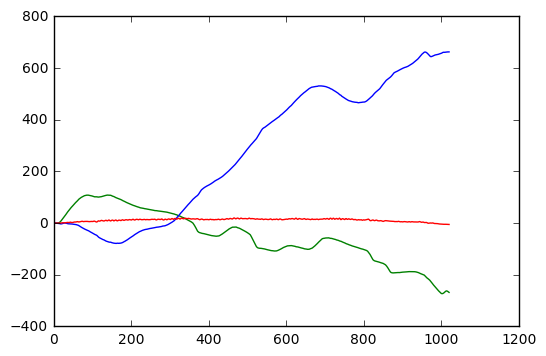

In [43]:
plt.plot(np.cumsum(run.ax),color='green')
plt.plot(np.cumsum(run.ay),color='blue')
plt.plot(np.cumsum(run.az),color='red')

In [44]:
run.fc_kv = (run.fl_kv+run.fr_kv)/2
run.fc_v =( run.fl_v+run.fr_v)/2

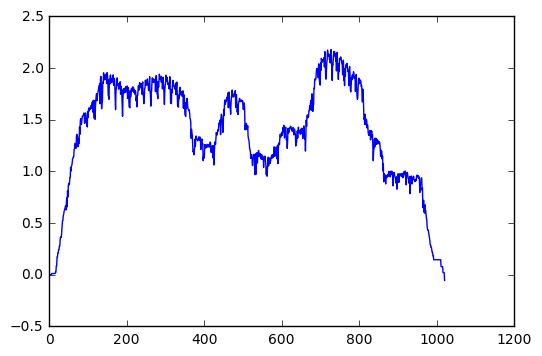

In [45]:
plt.plot(run.fl_v)

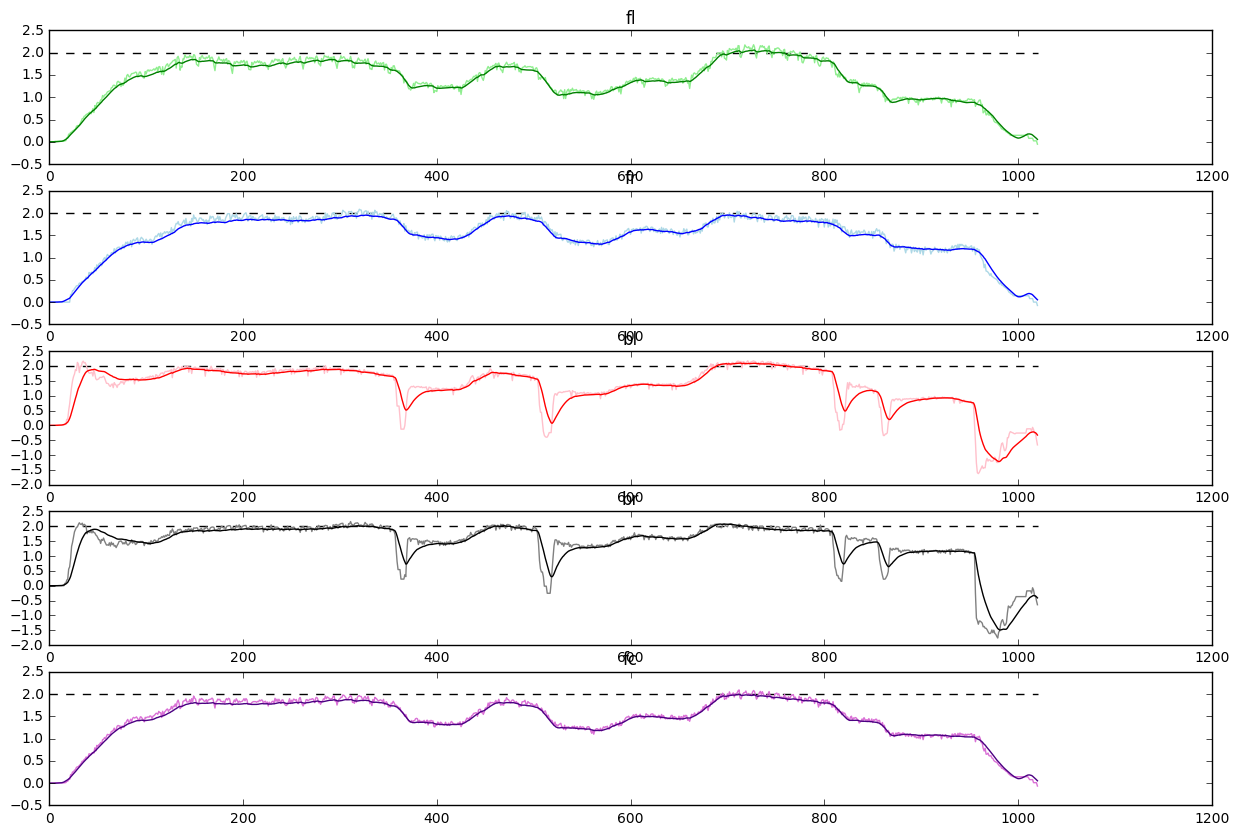

In [46]:
v_line = run_config['max_v']

big_figure()
plt.subplot(5,1,1)
plt.title('fl')
plt.plot(run.fl_v,color='lightgreen')
plt.plot(run.fl_kv,color='green')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,2)
plt.title('fr')
plt.plot(run.fr_v,color='lightblue')
plt.plot(run.fr_kv,color='blue')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,3)
plt.title('bl')
plt.plot(run.bl_v,color='pink')
plt.plot(run.bl_kv,color='red')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,4)
plt.title('br')
plt.plot(run.br_v,color='gray')
plt.plot(run.br_kv,color='black')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,5)
plt.title('fc')
plt.plot(run.fc_v,color='orchid')
plt.plot(run.fc_kv,color='indigo')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

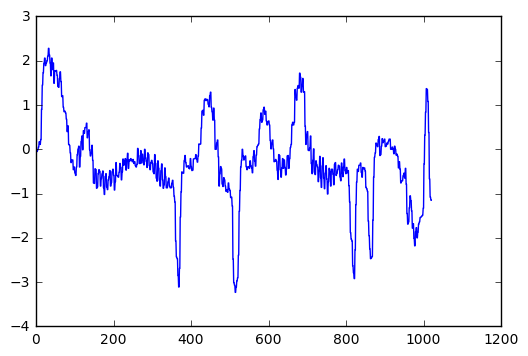

In [47]:
plt.plot(run.ax)

1733164484


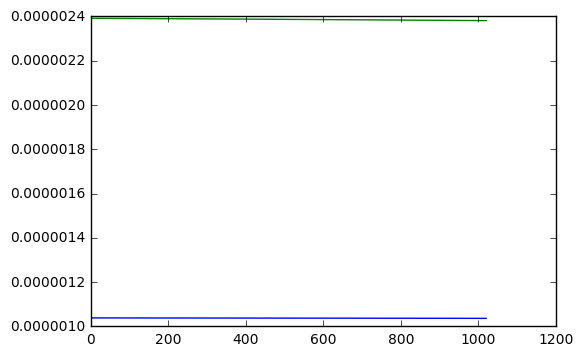

In [48]:
plt.plot(1/run.odo_fl_ab_us*1800)
plt.plot(1/run.odo_fr_ab_us*1800)
#plt.plot(1/run.odo_bl_ab_us)*1800
#plt.plot(1/run.odo_br_ab_us*1800)

print(min(abs(run.odo_fl_ab_us)))

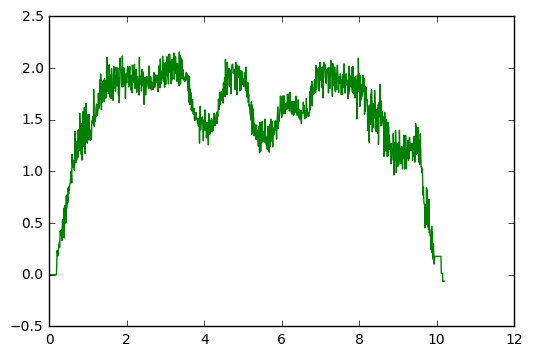

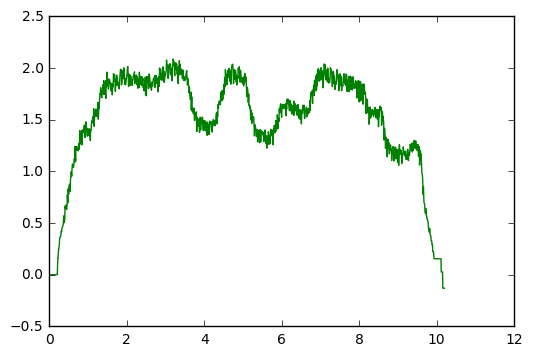

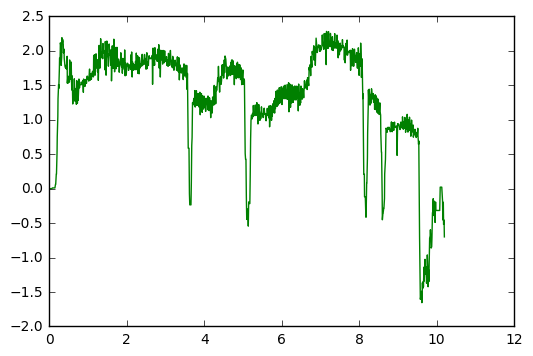

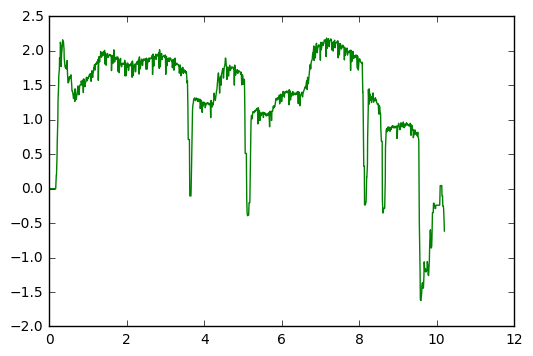

In [49]:
plt.figure()
plt.plot(run.t,raw_v(run.odo_fr,run.odo_fr_us,front_meters_per_odometer_tick),color='green')
plt.figure()
plt.plot(run.t,raw_v(run.odo_fr_a,run.odo_fr_a_us,2*front_meters_per_odometer_tick),color='green')
#plt.plot(run.t,raw_v(run.odo_fr_a,run.odo_fr_a_us,front_meters_per_odometer_tick*2),color='blue')
plt.figure()
plt.plot(run.t,raw_v(run.odo_bl,run.odo_bl_us,front_meters_per_odometer_tick),color='green')
plt.figure()
plt.plot(run.t,raw_v(run.odo_bl_a,run.odo_bl_a_us,2*front_meters_per_odometer_tick),color='green')


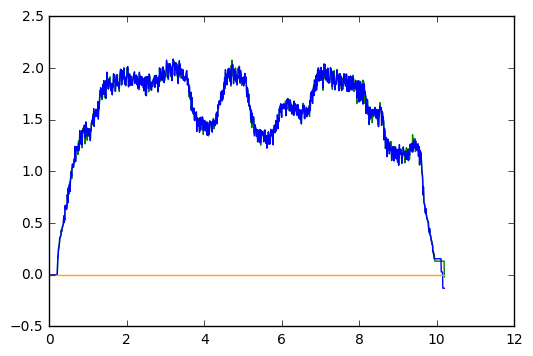

In [50]:
plt.plot(run.t,raw_v(run.odo_fr_b,run.odo_fr_b_us,front_meters_per_odometer_tick*2),color='green')
plt.plot(run.t,raw_v(run.odo_fr_a,run.odo_fr_a_us,front_meters_per_odometer_tick*2),color='blue')
plt.plot(run.t, 1/run.odo_fr_ab_us*1600,color='orange')

In [51]:
fig = plt.figure()
plt.plot(run.t, 1/run.odo_fr_ab_us*1600,color='green')
plt.plot(run.t, 1/run.odo_fl_ab_us*1600,color='blue')
plt.plot(run.t, 1/run.odo_br_ab_us*1600,color='red')
plt.plot(run.t, 1/run.odo_bl_ab_us*1600,color='orange')
py.iplot_mpl(fig)

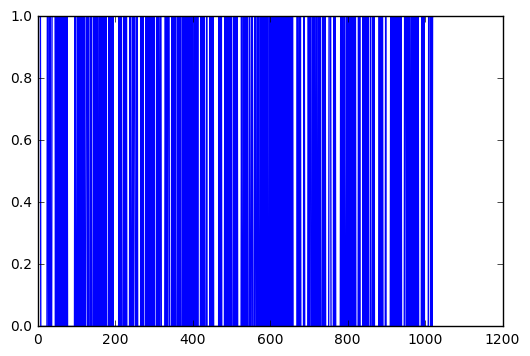

In [52]:
plt.plot(run.odo_bl_a - run.odo_bl_b)

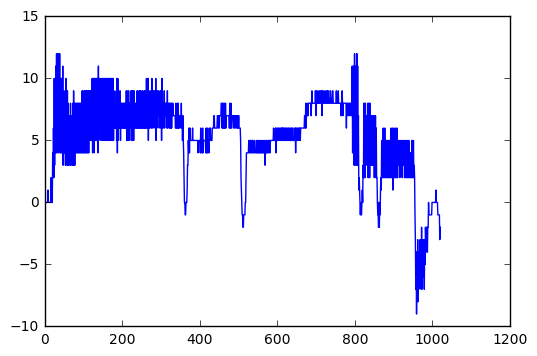

In [53]:
#plt.plot(run.t,raw_v(run.odo_bl_b,run.odo_bl_b_us,front_meters_per_odometer_tick*2),color='green')
#plt.plot(run.t,raw_v(run.odo_bl_a,run.odo_bl_a_us,front_meters_per_odometer_tick*2),color='blue')
#plt.plot(run.t, max(1/run.odo_bl_ab_us*1600,50),color='orange')
plt.plot(diff_n(run.odo_bl,1))


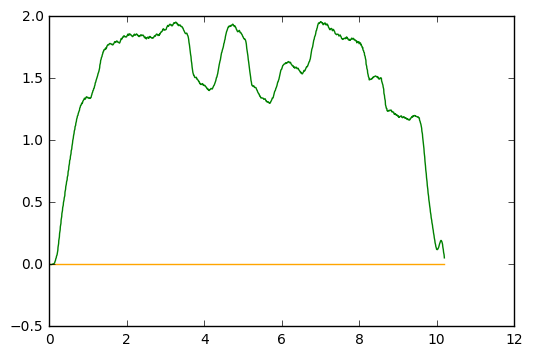

In [54]:
plt.plot(run.t, 1/run.odo_fr_ab_us*1600,color='orange')
plt.plot(run.t ,run.fr_kv, color='green')

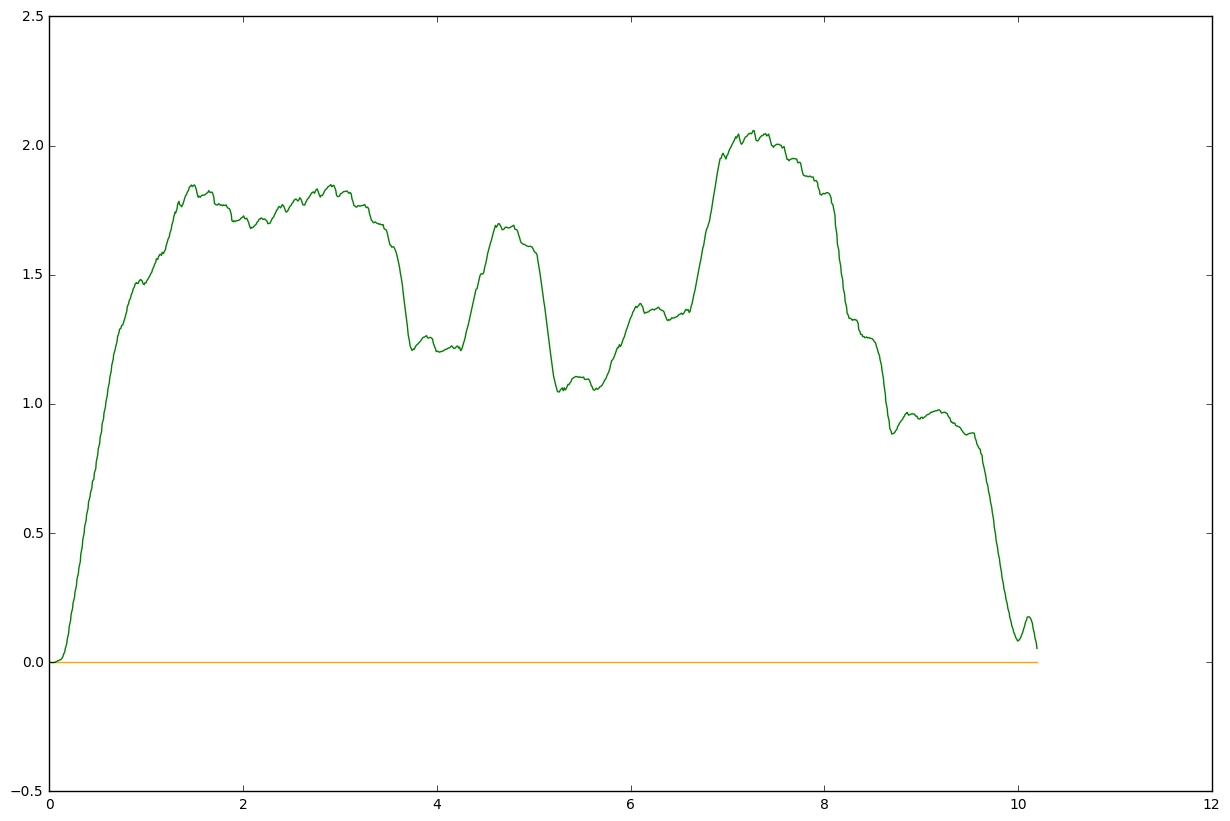

In [55]:
big_figure()
plt.plot(run.t, 1/run.odo_fl_ab_us*1600,color='orange')
plt.plot(run.t ,run.fl_kv, color='green')

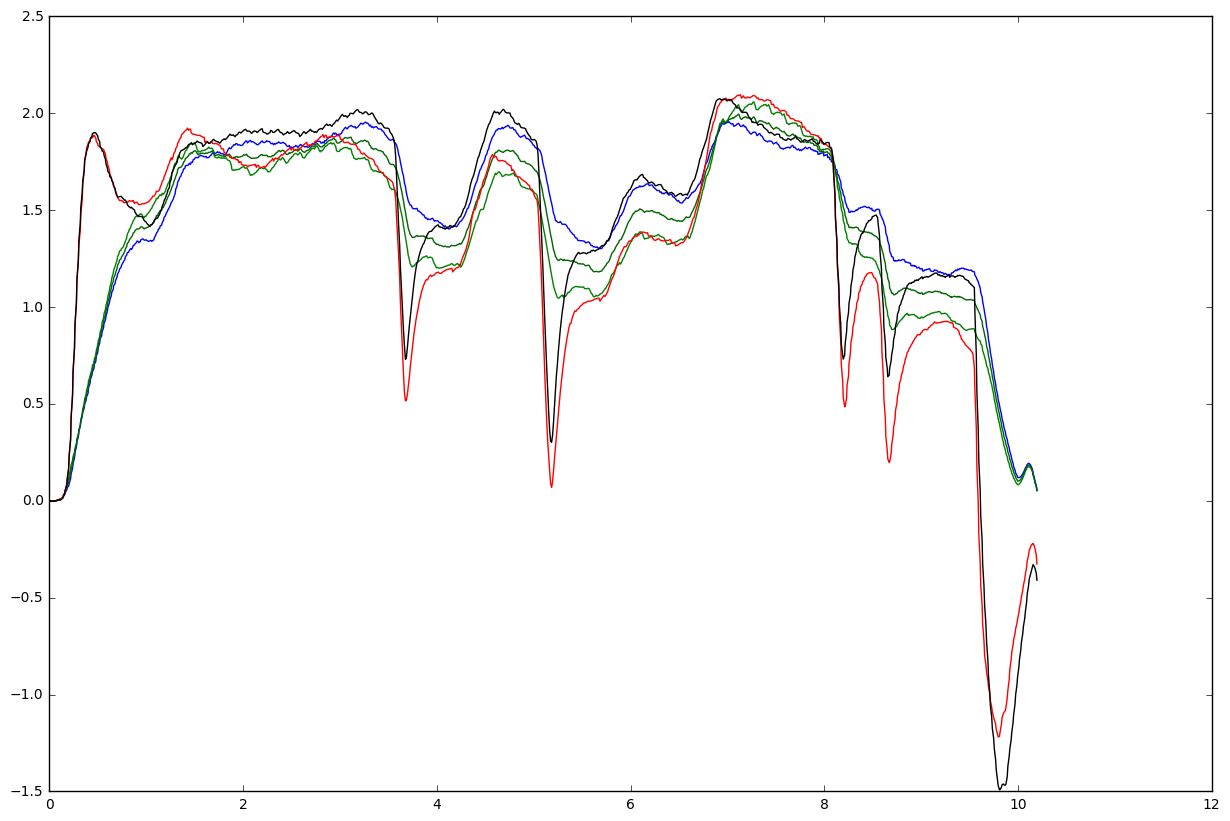

In [56]:
big_figure()
#plt.subplot(2,1,1)
plt.plot(run.t ,run.fl_kv, color='green')
plt.plot(run.t, run.fr_kv, color='blue')
plt.plot(run.t, run.fc_kv, color='darkgreen')
#plt.subplot(2,1,2)
plt.plot(run.t, run.bl_kv, color='red')
plt.plot(run.t, run.br_kv, color='black')


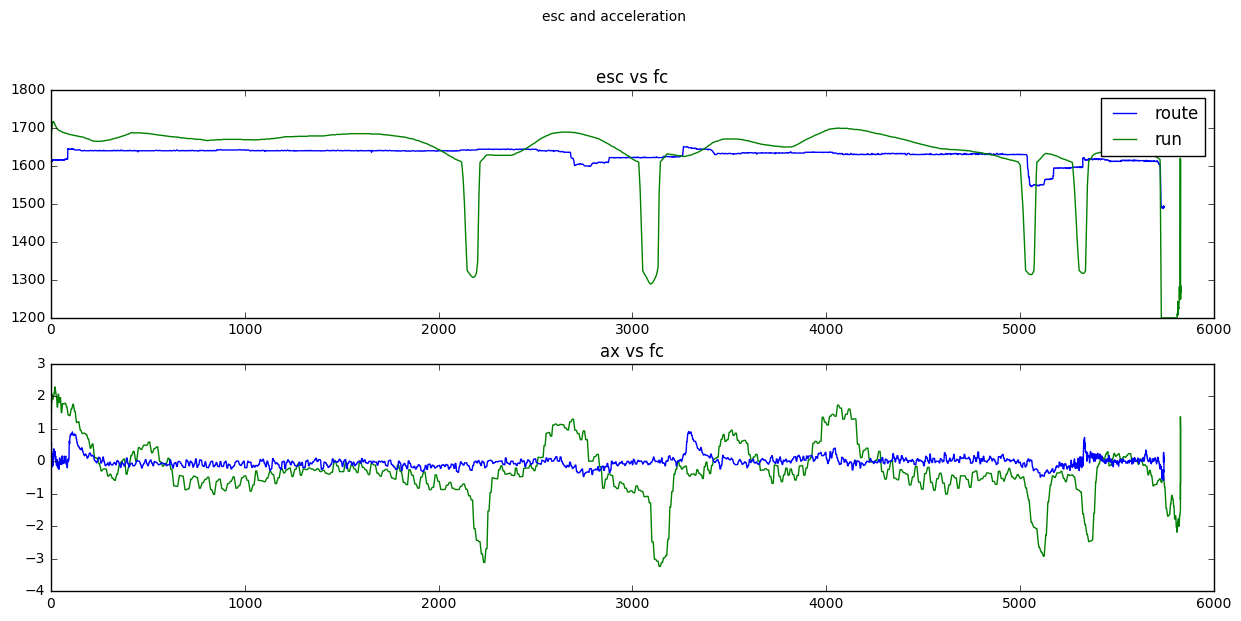

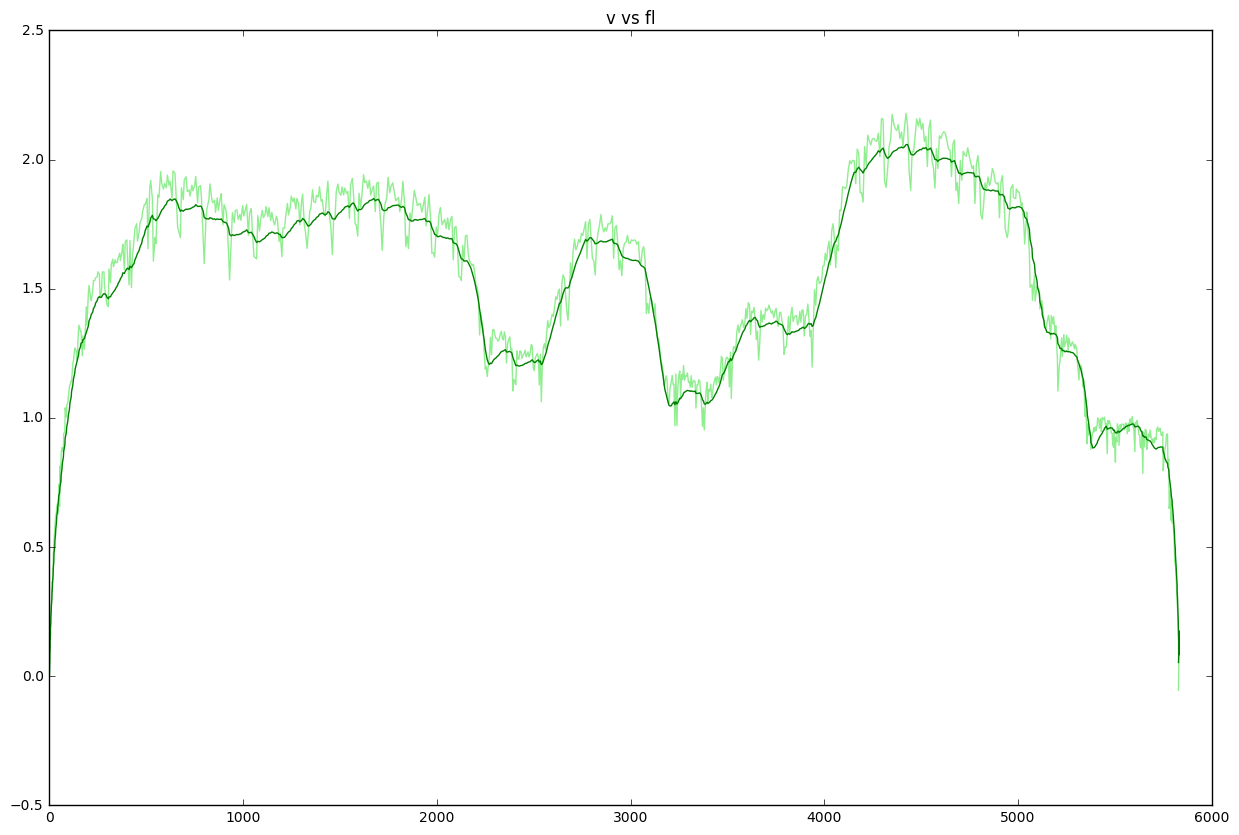

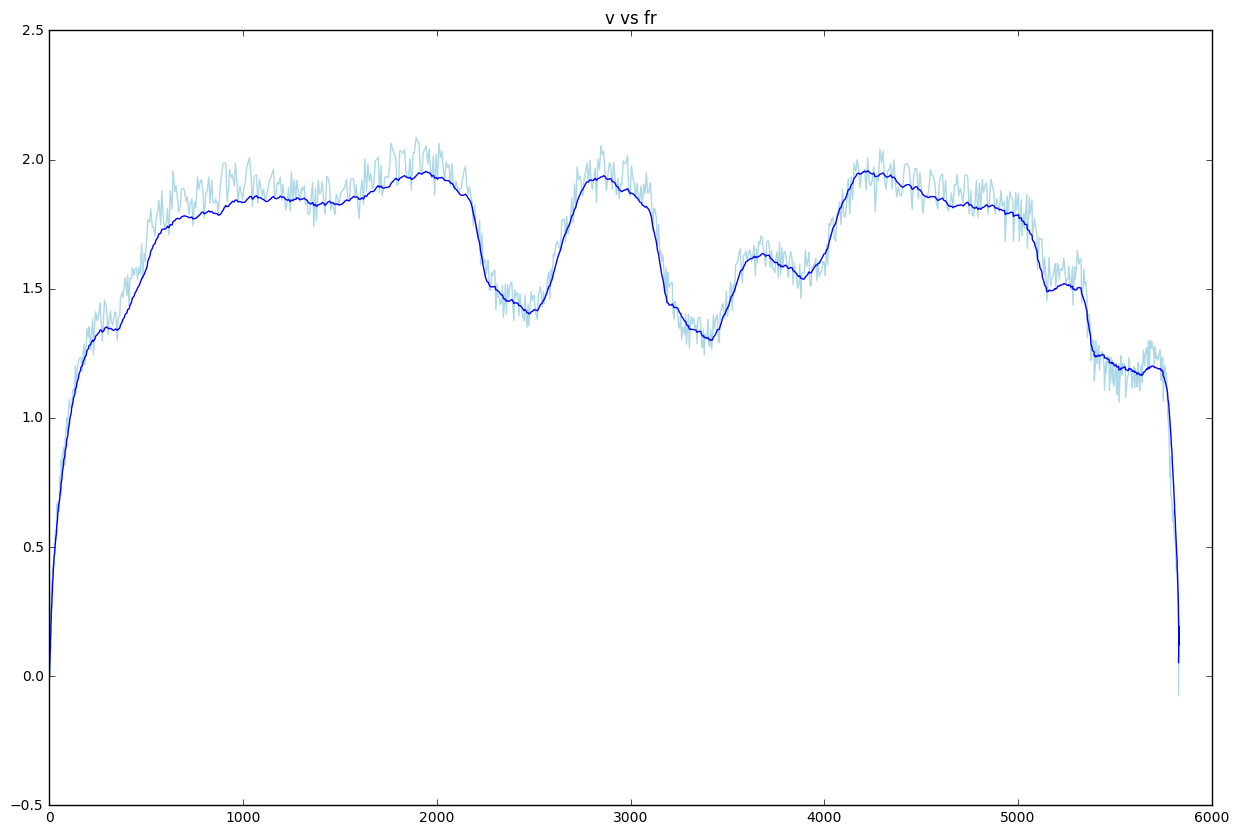

In [57]:
# research velocity
fig = big_figure()
fig.suptitle("esc and acceleration")
plt.subplot(3,1,1)
plt.plot(route.fc, route.esc, color='b',label='route')
plt.plot(run.fc, run.esc, color='g',label='run')
plt.legend()
plt.title("esc vs fc")
plt.subplot(3,1,2)
plt.title('ax vs fc')
plt.plot(run.fc, run.ax,color='g');
plt.plot(route.fc, route.ax,color='b');

big_figure()

plt.title('v vs fl')
plt.plot(run.fc, run.fl_v,color='lightgreen',label='direct');
plt.plot(run.fc, run.fl_kv,color='g',label='kalman');

big_figure()

plt.title('v vs fr')
plt.plot(run.fc, run.fr_v,color='lightblue');
plt.plot(run.fc, run.fr_kv,color='blue');

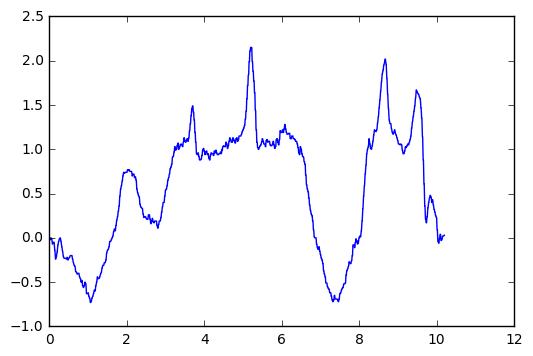

In [58]:
plt.plot(run.t,diff_n(run.heading,2));

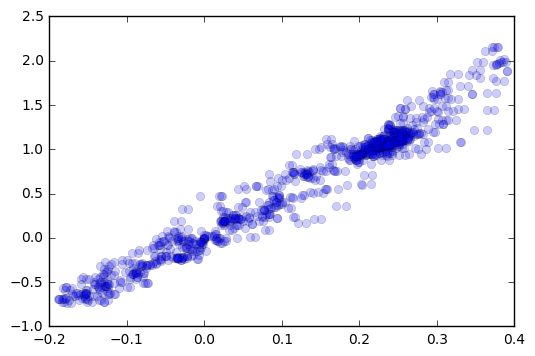

In [59]:
# How does wheel speed difference compare to turn rate?
run.dtheta=diff_n(run.heading,2)
plt.plot(run.fr_kv-run.fl_kv, run.dtheta,"o",alpha=0.2);

In [60]:
run.dtheta=diff_n(run.heading,2)
plt.plot(run.br_kv-run.bl_kv, run.dtheta,"o",alpha=0.2);
iplot()

In [61]:

x = {'b':3,'a':4}

In [62]:
sorted(x.keys())

['a', 'b']

In [63]:
def bar_chart(d):
    '''
    plots a bar chart for dictionary d
    '''
    labels = sorted(d.keys())
    values = [d[label] for label in labels]
    

    plt.bar(range(len(d)), values, align='center')
    plt.xticks(range(len(d)), labels,rotation=90,size=12)
    return plt

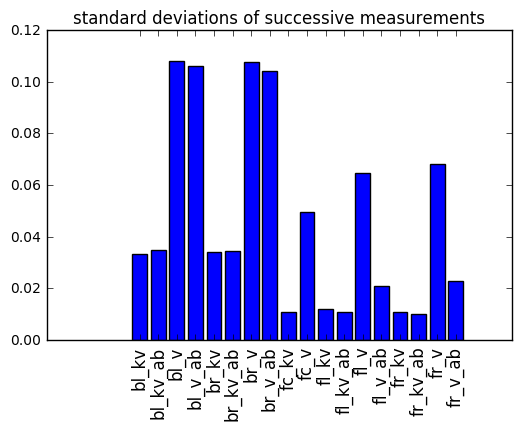

In [64]:
import collections
d = collections.OrderedDict({
    'fl_v':np.std(np.diff(run.fl_v)),
    'fr_v':np.std(np.diff(run.fr_v)),
    'fc_v':np.std(np.diff(run.fc_v)),
    'fl_v_ab':np.std(np.diff(run.fl_v_ab)),
    'fr_v_ab':np.std(np.diff(run.fr_v_ab)),
    'bl_v_ab':np.std(np.diff(run.bl_v_ab)),
    'br_v_ab':np.std(np.diff(run.br_v_ab)),
    'fl_kv_ab':np.std(np.diff(run.fl_kv_ab)),
    'fr_kv_ab':np.std(np.diff(run.fr_kv_ab)),
    'bl_kv_ab':np.std(np.diff(run.bl_kv_ab)),
    'br_kv_ab':np.std(np.diff(run.br_kv_ab)),
    'fl_kv':np.std(np.diff(run.fl_kv)),
    'fr_kv':np.std(np.diff(run.fr_kv)),
    'fc_kv':np.std(np.diff(run.fc_kv)),
    'bl_v':np.std(diff_n(run.bl_v)),
    'br_v':np.std(np.diff(run.br_v)),
    'bl_kv':np.std(np.diff(run.bl_kv)),
    'br_kv':np.std(np.diff(run.br_kv)),
})

bar_chart(d);
plt.title('standard deviations of successive measurements');

## Calculations made by the car

In [65]:
def kalman_a(a_raw,measure_variance=0.5**2):
    f = KalmanFilter(0,0)
    k_a = []
    for i,a in enumerate(a_raw):
        f.update(0.0,9*0.01**2)
        f.measure(a,measure_variance)
        k_a.append(f.mean)
    return np.array(k_a)

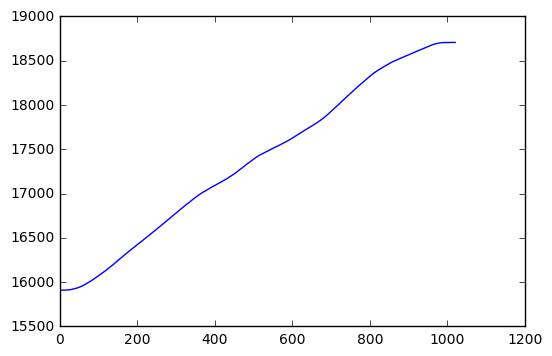

In [66]:
plt.plot(run.odo_fl_a)

In [76]:
big_figure()
plt.plot(run.t,run_state.a_fl_smooth)
plt.plot(run.t,run_state.a_fr_smooth)
plt.plot(run.t,run_state.a_bl_smooth)
plt.plot(run.t,run_state.a_br_smooth)
plt.plot(run.t,run_state.ax)

#plt.plot(run_state.a_fl_smooth,color='lightgray')
#plt.plot(kalman_a(run_state.a_fl_smooth),color='blue')
#plt.plot(kalman_a(kalman_a(run_state.a_fl_smooth)),color='blue')
iplot()


In [75]:
big_figure()
plt.plot(run.t, run_state.v_fl_smooth,color='green')
plt.plot(run.t,run_state.v_fr_smooth,color='blue')
plt.plot(run.t,run_state.v_bl_smooth,color='red')
plt.plot(run.t,run_state.v_br_smooth,color='orange')
plt.plot(run.t,run_state.v_smooth,color='black')
iplot()


In [69]:
run.columns


Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl_a',
       'odo_fl_a_us', 'odo_fl_b', 'odo_fl_b_us', 'odo_fl_ab_us', 'odo_fr_a',
       'odo_fr_a_us', 'odo_fr_b', 'odo_fr_b_us', 'odo_fr_ab_us', 'odo_bl_a',
       'odo_bl_a_us', 'odo_bl_b', 'odo_bl_b_us', 'odo_bl_ab_us', 'odo_br_a',
       'odo_br_a_us', 'odo_br_b', 'odo_br_b_us', 'odo_br_ab_us', 'odo_spur',
       'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax', 'ay', 'az', 'imu_calib',
       'odo_fl', 'odo_fl_us', 'fl', 'odo_fr', 'odo_fr_us', 'fr', 'odo_bl',
       'odo_bl_us', 'bl', 'odo_br', 'odo_br_us', 'br'],
      dtype='object')

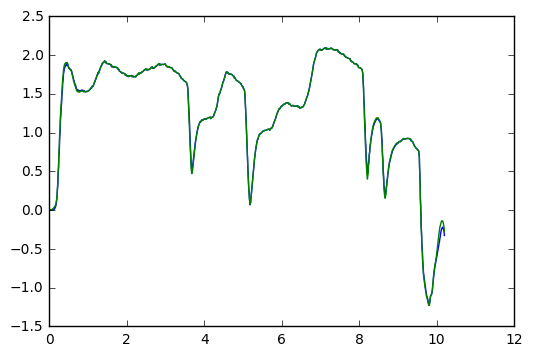

In [70]:
plt.plot(run.t, run.bl_kv)
plt.plot(run_state.t,run_state.v_bl_smooth)

In [71]:
big_figure()
plt.subplot(2,1,1)
plt.plot(run.t,run_state.a_fl_smooth,color='green')
plt.plot(run.t,run_state.a_fr_smooth,color='blue')
plt.plot(run.t,run_state.a_bl_smooth,color='red')
#plt.plot(run_state.a_br_smooth,color='orange')
plt.plot(run.t,run_state.a_smooth,color='black')
plt.subplot(2,1,2)
plt.plot(run.t,run_state.esc)
iplot()
print('std of noise in a_bl_smooth:', np.std(diff_n(run_state.a_bl_smooth)))

std of noise in a_bl_smooth: 0.0725643776947


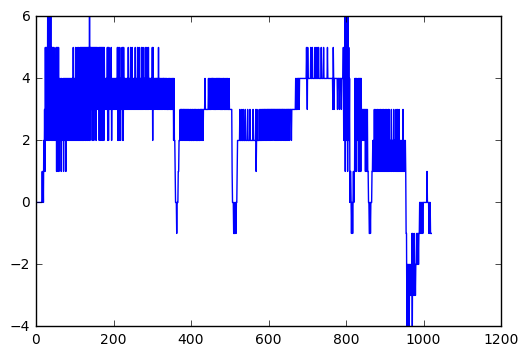

In [72]:
plt.plot(diff_n(run_state.odo_bl_a))

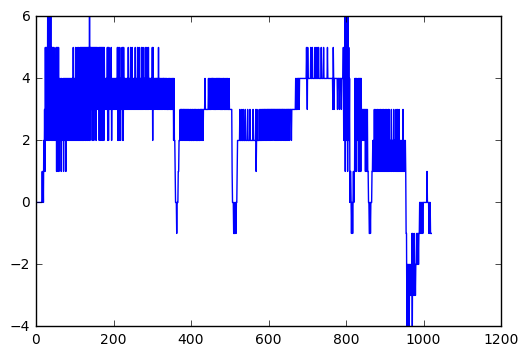

In [73]:
plt.plot(diff_n(run_state.odo_bl_a))